**Imports**

In [8]:
import os
import numpy as np
import shutil
import pandas as pd
import nibabel as nib
import cv2
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes, gaussian_filter
from skimage.morphology import remove_small_objects
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage import img_as_ubyte
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, recall_score, precision_score
from sklearn.metrics import roc_curve, auc

In [6]:
DATASET_PATH = "./brats2021"  
OUTPUT_PATH = "./output"  
PREPROCESSED_DATASET = "./output/train"  
SORTED_OUTPUT = "./output/splitClasses"
CSV_PATH = "./train_labels.csv" 
SORTED_DATASET = "./output/splitClasses" 
FILTERED_OUTPUT = "./output/filtered_dataset"  
PREPROCESSED_PATH = "./output/filtered_dataset" 
OUTPUT_FILE_PATH_GLCM = "./output/features/glcm_features.npz"
OUTPUT_FILE_PATH_HOG = "./output/features/hog_features.npz"
OUTPUT_FILE_PATH_LBP = "./output/features/lbp_features.npz"
DLRFE_FILE_PATH = "./output/features/trained_dlrfe_features.npz"
OUTPUT_FILE_PATH_HFS = "./output/features/hfs_features.npz"

**Preprocessing Steps**

**1️⃣ PNG Images  ➝  2️⃣ Stack to NIfTI  ➝  3️⃣ Gaussian Smoothing ➝  4️⃣ Skull Stripping ➝  5️⃣ Normalization ➝  6️⃣ Convert to PNG**


In [ ]:
class BrainMRIPreprocessor:
    def __init__(self, dataset_path, output_path, image_size=(128, 128)):
        self.dataset_path = dataset_path
        self.output_path = output_path
        self.image_size = image_size
        self.mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]

    """Stacks PNG images into a single 3D NIfTI volume."""
    def stack_images_to_nifti(self, image_folder):

        if not os.path.exists(image_folder):
            return None
        
        image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])
        if not image_files:
            return None

        stacked_images = []
        for file in image_files:
            img = cv2.imread(os.path.join(image_folder, file), cv2.IMREAD_GRAYSCALE)
            stacked_images.append(img)

        stacked_array = np.stack(stacked_images, axis=-1)  # Stack along last axis (Depth)
        return nib.Nifti1Image(stacked_array.astype(np.float32), affine=np.eye(4))

    """Applies Gaussian smoothing and skull stripping using Otsu's thresholding and morphology."""
    def skull_strip(self, nifti_img):
    
        img_data = nifti_img.get_fdata()

        # Apply Gaussian Smoothing
        smoothed_data = gaussian_filter(img_data, sigma=1)

        # Compute Otsu's threshold
        threshold = threshold_otsu(smoothed_data)
        brain_mask = smoothed_data > (threshold * 0.8)

        # Fill holes in the mask and remove small objects
        brain_mask = binary_fill_holes(brain_mask)
        brain_mask = remove_small_objects(brain_mask, min_size=200)

        # Apply the mask to the image
        stripped_img = smoothed_data * brain_mask
        return nib.Nifti1Image(stripped_img, affine=nifti_img.affine)

    """Normalizes the intensity while preserving contrast, preventing division errors."""
    def normalize(self, nifti_img):
        
        img_data = nifti_img.get_fdata()

        min_val, max_val = np.percentile(img_data, (1, 99))  # Exclude extreme outliers
    
        # Fix division by zero issue
        if max_val - min_val == 0:
            norm_data = img_data  # Keep original values instead of dividing
        else:
            norm_data = np.clip((img_data - min_val) / (max_val - min_val + 1e-8), 0, 1)

        return nib.Nifti1Image(norm_data, affine=nifti_img.affine)

    """Saves the most representative slice (middle slice) as the final PNG."""
    def save_preprocessed_image(self, preprocessed_data, save_path):
        
        img_data = preprocessed_data.get_fdata()
        middle_index = img_data.shape[-1] // 2  # Select middle slice
        final_img = (img_data[:, :, middle_index] * 255).astype(np.uint8)
        cv2.imwrite(save_path, final_img)

    """Processes all MRI types for a single patient and saves output."""
    def process_patient(self, patient_path, output_patient_path):
        
        os.makedirs(output_patient_path, exist_ok=True)

        for mri_type in self.mri_types:
            input_mri_path = os.path.join(patient_path, mri_type)
            output_mri_path = os.path.join(output_patient_path, mri_type)
            os.makedirs(output_mri_path, exist_ok=True)

            nifti_img = self.stack_images_to_nifti(input_mri_path)
            if nifti_img is None:
                continue

            # Step 1: Skull Stripping (Includes Gaussian Smoothing)
            skull_stripped_nifti = self.skull_strip(nifti_img)

            # Step 2: Normalization
            normalized_nifti = self.normalize(skull_stripped_nifti)

            # Step 3: Save Final Image
            final_image_path = os.path.join(output_mri_path, "preprocessed.png")
            self.save_preprocessed_image(normalized_nifti, final_image_path)

    """Runs preprocessing on the full dataset (train + test)."""
    def run_preprocessing(self):
        
        for split in ["train", "test"]:
            split_path = os.path.join(self.dataset_path, split)
            output_split_path = os.path.join(self.output_path, split)

            patient_folders = sorted(os.listdir(split_path))
            for patient in tqdm(patient_folders, desc=f"Processing {split} set"):
                patient_path = os.path.join(split_path, patient)
                output_patient_path = os.path.join(output_split_path, patient)
                self.process_patient(patient_path, output_patient_path)

        print("Preprocessing completed for entire dataset! 🚀")

# ATLAS_PATH = "./sri24_spm8/templates/T1_brain.nii"

preprocessor = BrainMRIPreprocessor(DATASET_PATH, OUTPUT_PATH)
preprocessor.run_preprocessing()

Processing test set: 100%|██████████| 87/87 [23:14<00:00, 16.03s/it]

Preprocessing completed for entire dataset! 🚀


**Split dataset in Two classes**

In [ ]:
class DatasetSorter:
    def __init__(self, dataset_path, output_path, csv_path):
        self.dataset_path = dataset_path
        self.output_path = output_path
        self.csv_path = csv_path

    def load_patient_classes(self):
        """Reads the CSV file and returns a dictionary mapping patient IDs to their MGMT class."""
        df = pd.read_csv(self.csv_path)  # Load CSV
        df["BraTS21ID"] = df["BraTS21ID"].astype(str).str.zfill(5)
        patient_classes = dict(zip(df["BraTS21ID"], df["MGMT_value"]))
        return patient_classes

    def sort_patients(self):
        """Sorts patients into MGMT- and MGMT+ folders based on the CSV file."""
        patient_classes = self.load_patient_classes()
        mgmt_neg_path = os.path.join(self.output_path, "MGMT-")
        mgmt_pos_path = os.path.join(self.output_path, "MGMT+")
        os.makedirs(mgmt_neg_path, exist_ok=True)
        os.makedirs(mgmt_pos_path, exist_ok=True)

        for patient_id in tqdm(os.listdir(self.dataset_path), desc="Sorting patients"):
            patient_path = os.path.join(self.dataset_path, patient_id)
            if not os.path.isdir(patient_path):
                continue 
            
            if patient_id in patient_classes:
                class_label = "MGMT+" if patient_classes[patient_id] == 1 else "MGMT-"
                output_class_path = os.path.join(self.output_path, class_label) 
                shutil.copytree(patient_path, os.path.join(output_class_path, patient_id)) 

        print("✅ Dataset sorted into MGMT- and MGMT+!")




sorter = DatasetSorter(PREPROCESSED_DATASET, SORTED_OUTPUT, CSV_PATH)
sorter.sort_patients() 

Sorting patients: 100%|██████████| 585/585 [00:03<00:00, 166.80it/s]

✅ Dataset sorted into MGMT- and MGMT+!


**Rejection Algo**

In [22]:
class RejectionAlgorithm:
    def __init__(self, dataset_path, output_path, pixel_sum_threshold=500, brain_area_threshold=0.02):
        """
        dataset_path: Path to sorted dataset (MGMT- and MGMT+)
        output_path: Path to save the filtered dataset
        pixel_sum_threshold: Minimum sum of pixel values to keep an image
        brain_area_threshold: Minimum fraction of nonzero pixels (relative to total area)
        """
        self.dataset_path = dataset_path
        self.output_path = output_path
        self.pixel_sum_threshold = pixel_sum_threshold  # Reject images with very low total intensity
        self.brain_area_threshold = brain_area_threshold  # Reject images with very small visible brain area
        self.classes = ["MGMT-", "MGMT+"]  # Process both MGMT- and MGMT+ classes

    def process_class(self, class_label):
        """Processes a single class (MGMT- or MGMT+) and removes low-quality images."""
        input_class_path = os.path.join(self.dataset_path, class_label)
        output_class_path = os.path.join(self.output_path, class_label)
        os.makedirs(output_class_path, exist_ok=True)

        rejected_count = 0
        rejected_files = []

        for patient in tqdm(sorted(os.listdir(input_class_path)), desc=f"Processing {class_label}"):
            patient_path = os.path.join(input_class_path, patient)
            output_patient_path = os.path.join(output_class_path, patient)
            os.makedirs(output_patient_path, exist_ok=True)

            for mri_type in ["FLAIR", "T1w", "T1wCE", "T2w"]:
                input_mri_path = os.path.join(patient_path, mri_type)
                output_mri_path = os.path.join(output_patient_path, mri_type)
                os.makedirs(output_mri_path, exist_ok=True)

                if not os.path.exists(input_mri_path):
                    continue

                valid_images = 0  # Track number of valid images in this folder

                for img_file in sorted(os.listdir(input_mri_path)):
                    if not img_file.endswith(".png"):
                        continue

                    img_path = os.path.join(input_mri_path, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    # Compute sum of pixel values
                    pixel_sum = np.sum(img)

                    # Compute brain area (percentage of nonzero pixels)
                    brain_area = np.count_nonzero(img) / img.size  # Fraction of nonzero pixels

                    # Check if image should be rejected
                    if pixel_sum < self.pixel_sum_threshold or brain_area < self.brain_area_threshold:
                        rejected_count += 1
                        rejected_files.append(img_path)
                    else:
                        # Copy valid image to output directory
                        output_img_path = os.path.join(output_mri_path, img_file)
                        shutil.copy2(img_path, output_img_path)
                        valid_images += 1  # Increase valid image count

                # Remove empty MRI type folder if no images remain
                if valid_images == 0:
                    shutil.rmtree(output_mri_path)

        print(f"✅ Rejection completed for {class_label}: {rejected_count} images removed.")

        # Save log of rejected images
        log_path = os.path.join(self.output_path, f"rejected_{class_label}.txt")
        with open(log_path, "w") as log_file:
            for file in rejected_files:
                log_file.write(file + "\n")

    def run_rejection(self):
        """Runs the rejection algorithm for both MGMT- and MGMT+ classes."""
        os.makedirs(self.output_path, exist_ok=True)

        for class_label in self.classes:
            self.process_class(class_label)

        print("✅ Rejection Algorithm completed for the entire dataset!")



rejection = RejectionAlgorithm(SORTED_DATASET, FILTERED_OUTPUT)
rejection.run_rejection() 


Processing MGMT-: 100%|██████████| 278/278 [00:02<00:00, 119.56it/s]


✅ Rejection completed for MGMT-: 181 images removed.


Processing MGMT+: 100%|██████████| 307/307 [00:02<00:00, 115.60it/s]

✅ Rejection completed for MGMT+: 195 images removed.
✅ Rejection Algorithm completed for the entire dataset!


**GLCM feature extraction module**

In [23]:
class GLCMExtractor:
    def __init__(self, preprocessed_path, output_file_path, image_size=(128, 128), 
                 distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256):
        """
        Initializes the GLCM extractor with:
        - preprocessed_path: Path to MRI images
        - output_file_path: Single .npz file for output
        - image_size: Input image size (default: 128x128)
        - distances: List of pixel distances (default: [1])
        - angles: List of angles in radians (0°, 45°, 90°, 135°)
        - levels: Number of gray levels (default: 256)
        """
        self.preprocessed_path = preprocessed_path
        self.output_file_path = output_file_path
        self.image_size = image_size
        self.mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]
        self.distances = distances
        self.angles = angles
        self.levels = levels
        self.properties = ['energy', 'contrast', 'correlation', 'homogeneity'] 

    def compute_glcm(self, image):
        """Computes GLCM for an image using scikit-image."""
        # Convert to 8-bit integer for graycomatrix
        gray_img = img_as_ubyte(image)
        # Compute GLCM for multiple distances and angles
        glcm = graycomatrix(gray_img, distances=self.distances, angles=self.angles, 
                            levels=self.levels, symmetric=True, normed=True)
        return glcm  # Shape: (levels, levels, n_distances, n_angles)

    def compute_features(self, glcm):
        """Computes Haralick-like features, averaging over distances and angles."""
        features = []
        # scikit-image properties
        for prop in self.properties:
            feat = graycoprops(glcm, prop)  # Shape: (n_distances, n_angles)
            features.append(feat.ravel())   # Flatten to 1D

        # Stack basic features (energy, contrast, correlation, homogeneity)
        basic_features = np.concatenate(features)  # Shape: (4 * n_distances * n_angles)

        # Additional Haralick features (computed manually)
        px = np.sum(glcm, axis=1)  # Row probabilities
        py = np.sum(glcm, axis=0)  # Column probabilities
        mean_x = np.sum(np.arange(self.levels)[:, None, None] * px, axis=0)
        mean_y = np.sum(np.arange(self.levels)[None, :, None] * py, axis=1)
        std_x = np.sqrt(np.sum(((np.arange(self.levels)[:, None, None] - mean_x) ** 2) * px, axis=0))
        std_y = np.sqrt(np.sum(((np.arange(self.levels)[None, :, None] - mean_y) ** 2) * py, axis=1))

        # Compute for each distance-angle pair
        extra_features = []
        for d in range(len(self.distances)):
            for a in range(len(self.angles)):
                g = glcm[:, :, d, a]
                px_g = px[:, d, a]
                py_g = py[:, d, a]
                mx = mean_x[d, a]
                my = mean_y[d, a]
                sx = std_x[d, a]
                sy = std_y[d, a]

                # Sum Average
                sum_avg = np.sum((np.arange(self.levels) + 1) * px_g)
                # Sum Variance
                sum_var = np.sum(((np.arange(self.levels) + 1 - sum_avg) ** 2) * px_g)
                # Sum Entropy
                sum_entropy = -np.sum(px_g * np.log2(px_g + 1e-8))
                # Entropy
                entropy = -np.sum(g * np.log2(g + 1e-8))
                # Difference Variance (simplified)
                diff_var = np.sum((np.arange(self.levels) ** 2) * px_g)
                # Difference Entropy
                diff_entropy = -np.sum(px_g * np.log2(px_g + 1e-8))
                # Information Measures (simplified)
                hxy = entropy
                hxy1 = -np.sum(g * np.log2(px_g[:, None] * py_g[None, :] + 1e-8))
                hxy2 = -np.sum(px_g[:, None] * py_g[None, :] * np.log2(px_g[:, None] * py_g[None, :] + 1e-8))
                imc1 = (hxy - hxy1) / (hxy + 1e-8)
                imc2 = np.sqrt(1 - np.exp(-2 * (hxy2 - hxy)))

                extra_features.append([sum_avg, sum_var, sum_entropy, entropy, diff_var, diff_entropy, imc1, imc2])

        extra_features = np.mean(extra_features, axis=0)  # Average over directions
        return np.concatenate([basic_features, extra_features])  # Total: 4*4 + 8 = 24 features

    def load_and_process_image(self, patient_path, mri_type):
        """Loads and processes a single MRI image."""
        img_path = os.path.join(patient_path, mri_type, "preprocessed.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img.shape != self.image_size:
                img = cv2.resize(img, self.image_size)
            return img.astype(np.float32) / 255.0
        else:
            # print(f"Warning: Missing {img_path}, using zero image")
            return np.zeros(self.image_size, dtype=np.float32)

    def process_patient(self, patient_path, label):
        """Processes a single patient and returns GLCM features."""
        try:
            patient_features = []
            for mri_type in self.mri_types:
                img = self.load_and_process_image(patient_path, mri_type)
                glcm = self.compute_glcm(img)
                glcm_feats = self.compute_features(glcm)
                patient_features.append(glcm_feats)
            
            # Stack features: 4 modalities * 24 features = 96 features
            combined_features = np.concatenate(patient_features)
            patient_id = os.path.basename(patient_path)
            return {'patient_id': patient_id, 'features': combined_features, 'label': label}
        except Exception as e:
            print(f"Error processing {patient_path}: {e}")
            return None

    def run_extraction(self):
        """Runs GLCM feature extraction and saves to a single .npz file."""
        all_data = []
        for mgmt_status in ["MGMT-", "MGMT+"]:
            mgmt_path = os.path.join(self.preprocessed_path, mgmt_status)
            label = 0 if mgmt_status == "MGMT-" else 1

            if not os.path.exists(mgmt_path):
                print(f"Skipping {mgmt_status}: directory not found.")
                continue

            patient_folders = sorted(os.listdir(mgmt_path))
            for patient in tqdm(patient_folders, desc=f"Extracting GLCM for {mgmt_status}"):
                patient_path = os.path.join(mgmt_path, patient)
                patient_data = self.process_patient(patient_path, label)
                if patient_data is not None:
                    all_data.append(patient_data)

        patient_ids = np.array([data['patient_id'] for data in all_data])
        features = np.array([data['features'] for data in all_data])  # Shape: (n_patients, 96)
        labels = np.array([data['label'] for data in all_data])
        np.savez(self.output_file_path, patient_ids=patient_ids, features=features, labels=labels)
        print(f"GLCM feature extraction completed! Saved to {self.output_file_path}")


extractor = GLCMExtractor(FILTERED_OUTPUT, OUTPUT_FILE_PATH_GLCM)
extractor.run_extraction()

Extracting GLCM for MGMT+: 100%|██████████| 307/307 [00:56<00:00,  5.41it/s]

GLCM feature extraction completed! Saved to ./output/features/glcm_features.npz


In [24]:
def check_glcm_features(npz_file_path, patient_id):
    data = np.load(npz_file_path)
    patient_ids = data['patient_ids']
    features = data['features']
    labels = data['labels']
    
    try:
        idx = np.where(patient_ids == patient_id)[0][0]
        print(f"Patient: {patient_id}")
        print(f"GLCM Features Shape: {features[idx].shape}")  # Should be (96,)
        print(f"GLCM Features (first 10): {features[idx][:10]}")  # Sample
        print(f"Label: {labels[idx]}")
    except IndexError:
        print(f"Patient {patient_id} not found.")

PATIENT_ID = "00000"  
check_glcm_features(OUTPUT_FILE_PATH_GLCM, PATIENT_ID)

Patient: 00000
GLCM Features Shape: (96,)
GLCM Features (first 10): [  0.856921   0.8535     0.856613   0.853623 190.190822 318.877178
 211.305856 325.905264   0.963432   0.939099]
Label: 1


***HOG features***

In [25]:
import os
import cv2
import numpy as np
from tqdm import tqdm

class HOGExtractor:
    def __init__(self, preprocessed_path, output_file_path, image_size=(128, 128), 
                 cell_size=(8, 8), block_size=(2, 2), bins=9, epsilon=1e-8):
        self.preprocessed_path = preprocessed_path
        self.output_file_path = output_file_path
        self.image_size = image_size
        self.mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]
        self.cell_size = cell_size
        self.block_size = block_size
        self.bins = bins
        self.epsilon = epsilon

    def compute_gradients(self, image):
        image = cv2.GaussianBlur(image, (3, 3), 0)
        image = image.astype(np.float32)  # Keep original range [0, 255]
        
        Ex = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        Ey = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        
        magnitude = np.sqrt(Ex ** 2 + Ey ** 2)
        angle = np.arctan2(Ey, Ex) * (180 / np.pi)
        angle[angle < 0] += 180
        
        max_mag = np.max(magnitude)
        # print(f"Gradient Magnitude - Min: {magnitude.min()}, Max: {max_mag}, Mean: {magnitude.mean()}")  # Debug
        if max_mag > 0:
            magnitude /= max_mag
        else:
            print("Warning: No gradients detected (max magnitude = 0)")
        
        return magnitude, angle

    def compute_histograms(self, magnitude, angle):
        h, w = magnitude.shape
        cell_h, cell_w = self.cell_size
        cells_x, cells_y = w // cell_w, h // cell_h
        histograms = np.zeros((cells_y, cells_x, self.bins))

        bin_size = 180 / self.bins
        for i in range(cells_y):
            for j in range(cells_x):
                cell_mag = magnitude[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]
                cell_ang = angle[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]
                hist, _ = np.histogram(cell_ang, bins=self.bins, range=(0, 180), weights=cell_mag)
                histograms[i, j] = hist
        
        # print(f"Histograms - Min: {histograms.min()}, Max: {histograms.max()}, Mean: {histograms.mean()}")  # Debug
        return histograms

    def normalize_blocks(self, histograms):
        cells_y, cells_x, bins = histograms.shape
        block_h, block_w = self.block_size
        normalized_hog = []

        for i in range(cells_y - block_h + 1):
            for j in range(cells_x - block_w + 1):
                block = histograms[i:i + block_h, j:j + block_w].flatten()
                norm_factor = np.sum(block) + self.epsilon
                normalized_block = np.sqrt(block / norm_factor)
                normalized_hog.extend(normalized_block)

        hog_descriptor = np.array(normalized_hog)
        # print(f"HOG Descriptor - Min: {hog_descriptor.min()}, Max: {hog_descriptor.max()}, Mean: {hog_descriptor.mean()}")  # Debug
        return hog_descriptor

    def extract_features(self, image):
        magnitude, angle = self.compute_gradients(image)
        histograms = self.compute_histograms(magnitude, angle)
        hog_descriptor = self.normalize_blocks(histograms)
        if np.all(hog_descriptor == 0):
            print("Warning: HOG features are all zeros")
        return hog_descriptor

    def load_and_process_image(self, patient_path, mri_type):
        img_path = os.path.join(patient_path, mri_type, "preprocessed.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img.shape != self.image_size:
                img = cv2.resize(img, self.image_size)
            if img.max() == 0:
                print(f"Skipping {img_path}: Image is all zeros")
                return None
            # print(f"Loaded {img_path} - Min: {img.min()}, Max: {img.max()}, Mean: {img.mean()}")  # Debug
            return img
        else:
            print(f"Skipping {img_path}: Missing modality")
            return None

    def process_patient(self, patient_path, label):
        try:
            patient_features = []
            for mri_type in self.mri_types:
                img = self.load_and_process_image(patient_path, mri_type)
                if img is None:
                    return None
                hog_feats = self.extract_features(img)
                patient_features.append(hog_feats)
            
            combined_features = np.concatenate(patient_features)
            patient_id = os.path.basename(patient_path)
            return {'patient_id': patient_id, 'features': combined_features, 'label': label}
        except Exception as e:
            print(f"Error processing {patient_path}: {e}")
            return None

    def run_extraction(self):
        all_data = []
        for mgmt_status in ["MGMT-", "MGMT+"]:
            mgmt_path = os.path.join(self.preprocessed_path, mgmt_status)
            label = 0 if mgmt_status == "MGMT-" else 1

            if not os.path.exists(mgmt_path):
                print(f"Skipping {mgmt_status}: directory not found.")
                continue

            patient_folders = sorted(os.listdir(mgmt_path))
            for patient in tqdm(patient_folders, desc=f"Extracting HOG for {mgmt_status}"):
                patient_path = os.path.join(mgmt_path, patient)
                patient_data = self.process_patient(patient_path, label)
                if patient_data is not None:
                    all_data.append(patient_data)

        patient_ids = np.array([data['patient_id'] for data in all_data])
        features = np.array([data['features'] for data in all_data])
        labels = np.array([data['label'] for data in all_data])
        np.savez(self.output_file_path, patient_ids=patient_ids, features=features, labels=labels)
        print(f"HOG feature extraction completed! Saved to {self.output_file_path}")


extractor = HOGExtractor(FILTERED_OUTPUT, OUTPUT_FILE_PATH_HOG)
extractor.run_extraction()

Extracting HOG for MGMT-:   5%|▌         | 14/278 [00:01<00:17, 14.80it/s]

Skipping ./output/filtered_dataset\MGMT-\00036\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00045\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT-:   6%|▌         | 17/278 [00:01<00:17, 15.13it/s]

Skipping ./output/filtered_dataset\MGMT-\00061\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  13%|█▎        | 37/278 [00:03<00:19, 12.49it/s]

Skipping ./output/filtered_dataset\MGMT-\00123\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00130\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  19%|█▉        | 54/278 [00:04<00:11, 19.57it/s]

Skipping ./output/filtered_dataset\MGMT-\00158\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00162\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00165\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00167\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00169\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  21%|██        | 57/278 [00:04<00:12, 17.96it/s]

Skipping ./output/filtered_dataset\MGMT-\00172\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  22%|██▏       | 62/278 [00:04<00:12, 17.36it/s]

Skipping ./output/filtered_dataset\MGMT-\00191\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00192\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  24%|██▎       | 66/278 [00:04<00:13, 15.56it/s]

Skipping ./output/filtered_dataset\MGMT-\00195\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  27%|██▋       | 76/278 [00:05<00:12, 16.65it/s]

Skipping ./output/filtered_dataset\MGMT-\00219\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00221\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00227\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00231\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00236\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00237\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  29%|██▉       | 81/278 [00:05<00:09, 20.44it/s]

Skipping ./output/filtered_dataset\MGMT-\00238\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00242\T1wCE\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  32%|███▏      | 88/278 [00:06<00:11, 16.24it/s]

Skipping ./output/filtered_dataset\MGMT-\00249\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  33%|███▎      | 92/278 [00:06<00:10, 17.10it/s]

Skipping ./output/filtered_dataset\MGMT-\00261\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00266\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00267\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  36%|███▌      | 99/278 [00:06<00:08, 19.91it/s]

Skipping ./output/filtered_dataset\MGMT-\00274\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00280\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00283\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  37%|███▋      | 102/278 [00:06<00:08, 21.11it/s]

Skipping ./output/filtered_dataset\MGMT-\00288\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00289\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00297\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00298\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  39%|███▉      | 109/278 [00:07<00:06, 25.01it/s]

Skipping ./output/filtered_dataset\MGMT-\00300\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00301\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00309\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00310\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00312\T1wCE\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  41%|████      | 113/278 [00:07<00:06, 24.13it/s]

Skipping ./output/filtered_dataset\MGMT-\00314\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00316\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  42%|████▏     | 116/278 [00:07<00:07, 20.61it/s]

Skipping ./output/filtered_dataset\MGMT-\00324\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00327\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  44%|████▎     | 121/278 [00:07<00:08, 18.69it/s]

Skipping ./output/filtered_dataset\MGMT-\00341\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00346\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00347\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  47%|████▋     | 131/278 [00:08<00:07, 19.66it/s]

Skipping ./output/filtered_dataset\MGMT-\00353\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00356\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00373\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00376\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00378\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  49%|████▉     | 136/278 [00:08<00:06, 22.45it/s]

Skipping ./output/filtered_dataset\MGMT-\00379\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00380\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00382\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  51%|█████     | 142/278 [00:08<00:07, 18.92it/s]

Skipping ./output/filtered_dataset\MGMT-\00391\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00392\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00397\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  54%|█████▍    | 151/278 [00:09<00:06, 20.10it/s]

Skipping ./output/filtered_dataset\MGMT-\00407\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00410\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00412\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00414\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00417\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  57%|█████▋    | 158/278 [00:09<00:05, 20.56it/s]

Skipping ./output/filtered_dataset\MGMT-\00421\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00423\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00430\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  60%|█████▉    | 166/278 [00:10<00:07, 15.99it/s]

Skipping ./output/filtered_dataset\MGMT-\00452\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00454\T1wCE\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  61%|██████    | 170/278 [00:10<00:07, 14.35it/s]

Skipping ./output/filtered_dataset\MGMT-\00464\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00481\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  65%|██████▌   | 181/278 [00:11<00:04, 22.05it/s]

Skipping ./output/filtered_dataset\MGMT-\00510\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00512\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00514\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00518\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00519\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00533\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00538\T2w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  68%|██████▊   | 188/278 [00:11<00:04, 21.65it/s]

Skipping ./output/filtered_dataset\MGMT-\00545\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00555\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  75%|███████▍  | 208/278 [00:12<00:03, 17.71it/s]

Skipping ./output/filtered_dataset\MGMT-\00601\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00605\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00616\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00619\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00623\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  80%|███████▉  | 222/278 [00:13<00:01, 36.68it/s]

Skipping ./output/filtered_dataset\MGMT-\00624\T2w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00630\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00636\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00641\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00642\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00645\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00649\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00651\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00654\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00657\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00663\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-

Extracting HOG for MGMT-:  84%|████████▍ | 233/278 [00:13<00:01, 38.38it/s]

Skipping ./output/filtered_dataset\MGMT-\00684\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00685\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00686\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00687\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00688\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00703\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00706\T2w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00709\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00724\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  85%|████████▌ | 237/278 [00:13<00:01, 30.79it/s]

Skipping ./output/filtered_dataset\MGMT-\00727\T1wCE\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  88%|████████▊ | 245/278 [00:13<00:01, 30.59it/s]

Skipping ./output/filtered_dataset\MGMT-\00733\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00734\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00735\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00742\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00744\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00751\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  91%|█████████ | 252/278 [00:14<00:00, 26.78it/s]

Skipping ./output/filtered_dataset\MGMT-\00756\T2w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00759\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00764\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00774\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00778\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT-:  99%|█████████▊| 274/278 [00:16<00:00, 14.20it/s]

Skipping ./output/filtered_dataset\MGMT-\00834\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00837\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00839\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\01004\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:   4%|▎         | 11/307 [00:00<00:21, 13.61it/s]

Skipping ./output/filtered_dataset\MGMT+\00020\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:   7%|▋         | 20/307 [00:01<00:20, 13.70it/s]

Skipping ./output/filtered_dataset\MGMT+\00048\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:   8%|▊         | 25/307 [00:01<00:19, 14.29it/s]

Skipping ./output/filtered_dataset\MGMT+\00060\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  10%|▉         | 30/307 [00:02<00:18, 14.73it/s]

Skipping ./output/filtered_dataset\MGMT+\00070\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  15%|█▌        | 47/307 [00:03<00:17, 14.45it/s]

Skipping ./output/filtered_dataset\MGMT+\00109\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00117\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  17%|█▋        | 51/307 [00:03<00:17, 14.82it/s]

Skipping ./output/filtered_dataset\MGMT+\00138\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  21%|██        | 64/307 [00:04<00:15, 15.22it/s]

Skipping ./output/filtered_dataset\MGMT+\00177\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00178\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  23%|██▎       | 72/307 [00:05<00:12, 18.99it/s]

Skipping ./output/filtered_dataset\MGMT+\00196\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00197\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00199\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00203\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  25%|██▍       | 76/307 [00:05<00:12, 19.08it/s]

Skipping ./output/filtered_dataset\MGMT+\00212\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00222\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00230\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00233\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  27%|██▋       | 83/307 [00:05<00:09, 23.07it/s]

Skipping ./output/filtered_dataset\MGMT+\00235\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00240\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00245\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00250\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  30%|██▉       | 91/307 [00:06<00:11, 18.45it/s]

Skipping ./output/filtered_dataset\MGMT+\00263\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00273\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  32%|███▏      | 99/307 [00:06<00:12, 16.05it/s]

Skipping ./output/filtered_dataset\MGMT+\00293\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00296\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00299\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  34%|███▍      | 105/307 [00:07<00:11, 17.98it/s]

Skipping ./output/filtered_dataset\MGMT+\00304\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00311\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  35%|███▍      | 107/307 [00:07<00:11, 18.01it/s]

Skipping ./output/filtered_dataset\MGMT+\00313\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  37%|███▋      | 114/307 [00:07<00:07, 26.78it/s]

Skipping ./output/filtered_dataset\MGMT+\00322\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00328\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00329\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00331\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00332\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00334\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  39%|███▉      | 120/307 [00:07<00:09, 20.52it/s]

Skipping ./output/filtered_dataset\MGMT+\00352\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00359\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  41%|████▏     | 127/307 [00:08<00:07, 22.51it/s]

Skipping ./output/filtered_dataset\MGMT+\00366\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00367\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00369\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00370\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00371\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00383\T1wCE\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  43%|████▎     | 133/307 [00:08<00:08, 21.24it/s]

Skipping ./output/filtered_dataset\MGMT+\00400\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00403\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00406\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00408\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  45%|████▌     | 139/307 [00:08<00:08, 20.49it/s]

Skipping ./output/filtered_dataset\MGMT+\00425\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00426\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00431\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  47%|████▋     | 144/307 [00:09<00:09, 17.93it/s]

Skipping ./output/filtered_dataset\MGMT+\00440\T1wCE\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  50%|█████     | 154/307 [00:09<00:09, 16.69it/s]

Skipping ./output/filtered_dataset\MGMT+\00468\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00472\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00479\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00480\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00483\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00485\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  53%|█████▎    | 163/307 [00:09<00:05, 24.05it/s]

Skipping ./output/filtered_dataset\MGMT+\00488\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00493\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00499\T1wCE\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  54%|█████▍    | 166/307 [00:10<00:07, 19.49it/s]

Skipping ./output/filtered_dataset\MGMT+\00500\T2w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  55%|█████▌    | 169/307 [00:10<00:07, 18.78it/s]

Skipping ./output/filtered_dataset\MGMT+\00505\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00513\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  58%|█████▊    | 177/307 [00:10<00:06, 21.47it/s]

Skipping ./output/filtered_dataset\MGMT+\00517\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00523\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00524\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00526\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00528\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00529\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  60%|█████▉    | 183/307 [00:10<00:04, 25.49it/s]

Skipping ./output/filtered_dataset\MGMT+\00537\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  62%|██████▏   | 189/307 [00:11<00:06, 19.27it/s]

Skipping ./output/filtered_dataset\MGMT+\00550\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  64%|██████▍   | 196/307 [00:11<00:06, 18.17it/s]

Skipping ./output/filtered_dataset\MGMT+\00556\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00558\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  71%|███████   | 217/307 [00:13<00:06, 14.94it/s]

Skipping ./output/filtered_dataset\MGMT+\00606\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00607\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00610\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00611\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00612\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00613\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  73%|███████▎  | 225/307 [00:13<00:03, 23.43it/s]

Skipping ./output/filtered_dataset\MGMT+\00618\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00621\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00625\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00626\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00628\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00631\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  76%|███████▌  | 234/307 [00:13<00:03, 22.96it/s]

Skipping ./output/filtered_dataset\MGMT+\00646\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00655\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  79%|███████▊  | 241/307 [00:14<00:02, 24.65it/s]

Skipping ./output/filtered_dataset\MGMT+\00658\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00661\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00674\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00675\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  80%|████████  | 247/307 [00:14<00:02, 22.50it/s]

Skipping ./output/filtered_dataset\MGMT+\00677\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00690\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  83%|████████▎ | 254/307 [00:14<00:02, 23.72it/s]

Skipping ./output/filtered_dataset\MGMT+\00692\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00693\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00694\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00698\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  85%|████████▍ | 260/307 [00:15<00:01, 25.53it/s]

Skipping ./output/filtered_dataset\MGMT+\00707\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00708\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00714\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00716\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00718\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00731\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  88%|████████▊ | 269/307 [00:15<00:01, 28.28it/s]

Skipping ./output/filtered_dataset\MGMT+\00732\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00736\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00739\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00740\FLAIR\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  91%|█████████ | 278/307 [00:15<00:00, 32.02it/s]

Skipping ./output/filtered_dataset\MGMT+\00758\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00760\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00765\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00768\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00772\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00775\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  97%|█████████▋| 299/307 [00:17<00:00, 15.34it/s]

Skipping ./output/filtered_dataset\MGMT+\00838\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00840\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:  99%|█████████▊| 303/307 [00:17<00:00, 14.83it/s]

Skipping ./output/filtered_dataset\MGMT+\01001\T1wCE\preprocessed.png: Missing modality


Extracting HOG for MGMT+: 100%|██████████| 307/307 [00:17<00:00, 17.17it/s]


Skipping ./output/filtered_dataset\MGMT+\01008\T1wCE\preprocessed.png: Missing modality
HOG feature extraction completed! Saved to ./output/features/hog_features.npz


In [26]:
def check_hog_features(npz_file_path, patient_id):
    data = np.load(npz_file_path)
    patient_ids = data['patient_ids']
    features = data['features']
    labels = data['labels']
    
    try:
        idx = np.where(patient_ids == patient_id)[0][0]
        np.set_printoptions(precision=6, suppress=True)
        print(f"Patient: {patient_id}")
        print(f"HOG Features Shape: {features[idx].shape}")
        print(f"HOG Features (first 10): {features[idx][:10]}")
        print(f"Label: {labels[idx]}")
        print("Features for 00184 (first 20):", features[idx][:20])
        print("Features for 00184 (100-120):", features[idx][100:120])
        print("Non-zero count:", np.sum(features[idx] != 0))
        print("Min:", features[idx].min(), "Max:", features[idx].max(), "Mean:", features[idx].mean())
    except IndexError:
        print(f"Patient {patient_id} not found.")

PATIENT_ID = "00184" 
check_hog_features(OUTPUT_FILE_PATH_HOG, PATIENT_ID)

Patient: 00184
HOG Features Shape: (32400,)
HOG Features (first 10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Features for 00184 (first 20): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Features for 00184 (100-120): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Non-zero count: 9974
Min: 0.0 Max: 0.9999999985294261 Mean: 0.05050869573233945


**LBP Features**

In [27]:
class LBPExtractor:
    def __init__(self, preprocessed_path, output_file_path, image_size=(128, 128), 
                 radius=1, n_points=8):
        """
        Initializes the LBP extractor with:
        - preprocessed_path: Path to MRI images
        - output_file_path: Single .npz file for output
        - image_size: Input image size (default: 128x128)
        - radius: Radius of the circular LBP (default: 1)
        - n_points: Number of neighboring points (default: 8)
        """
        self.preprocessed_path = preprocessed_path
        self.output_file_path = output_file_path
        self.image_size = image_size
        self.mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]
        self.radius = radius
        self.n_points = n_points
        self.n_bins = n_points + 2  # Uniform LBP bins: n_points + 2 (uniform + non-uniform)

    def compute_lbp_features(self, image):
        """Computes LBP features (histogram) for a single image."""
        # Convert to uint8 [0, 255]
        gray_img = img_as_ubyte(image)
        # Compute LBP
        lbp = local_binary_pattern(gray_img, P=self.n_points, R=self.radius, method='uniform')
        # Compute histogram
        hist, _ = np.histogram(lbp.ravel(), bins=self.n_bins, range=(0, self.n_bins), density=True)
        return hist  # Shape: (10,) with P=8, R=1

    def load_and_process_image(self, patient_path, mri_type):
        """Loads and processes a single MRI image."""
        img_path = os.path.join(patient_path, mri_type, "preprocessed.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img.shape != self.image_size:
                img = cv2.resize(img, self.image_size)
            if img.max() == 0:
                print(f"Skipping {img_path}: Image is all zeros")
                return None
            return img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        else:
            # print(f"Skipping {img_path}: Missing modality")
            return None

    def process_patient(self, patient_path, label):
        """Processes a single patient and returns LBP features."""
        try:
            patient_features = []
            for mri_type in self.mri_types:
                img = self.load_and_process_image(patient_path, mri_type)
                if img is None:
                    return None  # Skip if any modality is missing or invalid
                lbp_feats = self.compute_lbp_features(img)
                patient_features.append(lbp_feats)
            
            # Stack features: 4 modalities * n_bins features
            combined_features = np.concatenate(patient_features)  # Shape: (40,) with P=8
            patient_id = os.path.basename(patient_path)
            return {'patient_id': patient_id, 'features': combined_features, 'label': label}
        except Exception as e:
            print(f"Error processing {patient_path}: {e}")
            return None

    def run_extraction(self):
        """Runs LBP feature extraction and saves to a single .npz file."""
        all_data = []
        for mgmt_status in ["MGMT-", "MGMT+"]:
            mgmt_path = os.path.join(self.preprocessed_path, mgmt_status)
            label = 0 if mgmt_status == "MGMT-" else 1

            if not os.path.exists(mgmt_path):
                print(f"Skipping {mgmt_status}: directory not found.")
                continue

            patient_folders = sorted(os.listdir(mgmt_path))
            for patient in tqdm(patient_folders, desc=f"Extracting LBP for {mgmt_status}"):
                patient_path = os.path.join(mgmt_path, patient)
                patient_data = self.process_patient(patient_path, label)
                if patient_data is not None:
                    all_data.append(patient_data)

        patient_ids = np.array([data['patient_id'] for data in all_data])
        features = np.array([data['features'] for data in all_data])  # Shape: (n_patients, 40)
        labels = np.array([data['label'] for data in all_data])
        np.savez(self.output_file_path, patient_ids=patient_ids, features=features, labels=labels)
        print(f"LBP feature extraction completed! Saved to {self.output_file_path} 🚀")


extractor = LBPExtractor(FILTERED_OUTPUT, OUTPUT_FILE_PATH_LBP, radius=1, n_points=8)
extractor.run_extraction()

Extracting LBP for MGMT+: 100%|██████████| 307/307 [00:03<00:00, 92.15it/s] 

LBP feature extraction completed! Saved to ./output/features/lbp_features.npz 🚀


In [28]:

def check_lbp_features(npz_file_path, patient_id):
    data = np.load(npz_file_path)
    patient_ids = data['patient_ids']
    features = data['features']
    labels = data['labels']
    
    try:
        idx = np.where(patient_ids == patient_id)[0][0]
        print(f"Patient: {patient_id}")
        print(f"LBP Features Shape: {features[idx].shape}")
        print(f"LBP Features (first 10): {features[idx][:10]}")
        print(f"Non-zero count: {np.sum(features[idx] != 0)} out of {features[idx].size}")
        print(f"Label: {labels[idx]}")
    except IndexError:
        print(f"Patient {patient_id} not found.")

PATIENT_ID = "00000" 
check_lbp_features(OUTPUT_FILE_PATH_LBP, PATIENT_ID)

Patient: 00000
LBP Features Shape: (40,)
LBP Features (first 10): [0.010132 0.012024 0.008545 0.01947  0.024231 0.016052 0.011353 0.009827
 0.871399 0.016968]
Non-zero count: 40 out of 40
Label: 1


**DLRFE**

In [43]:
class MRIDataset(Dataset):
    def __init__(self, preprocessed_path, patient_ids, labels, image_size=(128, 128)):
        self.preprocessed_path = preprocessed_path
        self.patient_ids = patient_ids
        self.labels = labels
        self.image_size = image_size
        self.mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        label = self.labels[idx]
        patient_path = os.path.join(self.preprocessed_path, "MGMT-" if label == 0 else "MGMT+", patient_id)
        
        # Load and stack 4 modalities
        channels = []
        for mri_type in self.mri_types:
            img_path = os.path.join(patient_path, mri_type, "preprocessed.png")
            if os.path.exists(img_path):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img.shape != self.image_size:
                    img = cv2.resize(img, self.image_size)
                img = img.astype(np.float32) / 255.0
            else:
                img = np.zeros(self.image_size, dtype=np.float32)
            channels.append(img)
        
        image = np.stack(channels, axis=0)
        return torch.tensor(image), torch.tensor(label, dtype=torch.float32)


In [ ]:
class DLRFEModel(nn.Module):
    def __init__(self, input_shape=(4, 128, 128)):
        super(DLRFEModel, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 128x128 -> 64x64
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 64x64 -> 32x32
        self.bn2 = nn.BatchNorm2d(64)3
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)  # 32x32 -> 16x16
        self.dropout = nn.Dropout(0.5)
        # Latent Features
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Latent layer
        # Classification Head
        self.fc2 = nn.Linear(256, 1)  # Output for binary classification

    def forward(self, x, extract_features=False):
        x = torch.relu(self.conv1(x))
        # print(f"After Conv1: Min {x.min().item()}, Max {x.max().item()}")  # debug
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout(x)
        x = self.flatten(x)
        latent = self.fc1(x)  # Latent features (256,)
        if extract_features:
            # print(f"Latent Min: {latent.min().item()}, Max: {latent.max().item()}")
            return latent
        output = torch.sigmoid(self.fc2(latent))  # Classification output
        return output

In [45]:
def train_dlrfe(model, dataset, epochs=10, batch_size=4, lr=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for _, (images, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader):.4f}")

    return model

In [46]:
def extract_trained_features(model, dataset, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    model.eval()
    features = []
    labels = []
    patient_ids = []

    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    with torch.no_grad():
        for idx, (images, lbl) in enumerate(tqdm(dataloader, desc="Extracting Features")):
            images = images.to(device)
            feat = model(images, extract_features=True).cpu().numpy().flatten()
            features.append(feat)
            labels.append(lbl.numpy().item())
            patient_ids.append(dataset.patient_ids[idx])

    features = np.array(features)
    labels = np.array(labels)
    patient_ids = np.array(patient_ids)
    np.savez("./output/features/trained_dlrfe_features.npz", patient_ids=patient_ids, features=features, labels=labels)
    print(f"Trained DLRFE features saved to ./output/features/trained_dlrfe_features.npz")
    print(f"Features Shape: {features.shape}")
    print(f"Sample Features (patient {patient_ids[0]}): {features[0][:5]}")
    return features, labels, patient_ids


In [ ]:


glcm_data = np.load(OUTPUT_FILE_PATH_GLCM)
patient_ids = glcm_data['patient_ids'][:5]
labels = glcm_data['labels'][:5]
print(patient_ids, labels)
dataset = MRIDataset(FILTERED_OUTPUT, patient_ids, labels)
model = DLRFEModel()
trained_model = train_dlrfe(model, dataset, epochs=15, lr=0.0001)
trained_features, trained_labels, trained_patient_ids = extract_trained_features(trained_model, dataset)

['00003' '00009' '00017' '00018' '00019' '00021' '00022' '00024' '00030'
 '00032' '00036' '00044' '00045' '00049' '00053' '00061' '00064' '00072'
 '00081' '00084' '00088' '00090' '00095' '00097' '00099' '00102' '00104'
 '00108' '00110' '00111' '00112' '00113' '00116' '00121' '00122' '00123'
 '00124' '00130' '00132' '00133' '00137' '00142' '00147' '00148' '00149'
 '00150' '00151' '00154' '00157' '00158' '00162' '00165' '00167' '00169'
 '00170' '00172' '00176' '00183' '00184' '00191' '00192' '00193' '00194'
 '00195' '00201' '00206' '00209' '00211' '00214' '00216' '00217' '00218'
 '00219' '00221' '00227' '00228' '00231' '00236' '00237' '00238' '00239'
 '00241' '00242' '00243' '00247' '00249' '00251' '00258' '00259' '00261'
 '00262' '00266' '00267' '00269' '00274' '00275' '00280' '00283' '00286'
 '00288' '00289' '00290' '00297' '00298' '00300' '00301' '00308' '00309'
 '00310' '00312' '00314' '00316' '00318' '00320' '00324' '00325' '00327'
 '00336' '00339' '00341' '00343' '00346' '00347' '0

Epoch 1/15: 100%|██████████| 147/147 [00:20<00:00,  7.35it/s]


Epoch 1, Loss: 0.9861


Epoch 2/15: 100%|██████████| 147/147 [00:18<00:00,  7.83it/s]


Epoch 2, Loss: 0.6765


Epoch 3/15: 100%|██████████| 147/147 [00:19<00:00,  7.68it/s]


Epoch 3, Loss: 0.6421


Epoch 4/15: 100%|██████████| 147/147 [00:18<00:00,  7.79it/s]


Epoch 4, Loss: 0.5371


Epoch 5/15: 100%|██████████| 147/147 [00:18<00:00,  7.75it/s]


Epoch 5, Loss: 0.5104


Epoch 6/15: 100%|██████████| 147/147 [00:18<00:00,  7.75it/s]


Epoch 6, Loss: 0.4098


Epoch 7/15: 100%|██████████| 147/147 [00:19<00:00,  7.68it/s]


Epoch 7, Loss: 0.4449


Epoch 8/15: 100%|██████████| 147/147 [00:17<00:00,  8.28it/s]


Epoch 8, Loss: 0.3165


Epoch 9/15: 100%|██████████| 147/147 [00:18<00:00,  7.85it/s]


Epoch 9, Loss: 0.2897


Epoch 10/15: 100%|██████████| 147/147 [00:20<00:00,  7.30it/s]


Epoch 10, Loss: 0.2396


Epoch 11/15: 100%|██████████| 147/147 [00:19<00:00,  7.49it/s]


Epoch 11, Loss: 0.2648


Epoch 12/15: 100%|██████████| 147/147 [00:19<00:00,  7.53it/s]


Epoch 12, Loss: 0.2400


Epoch 13/15: 100%|██████████| 147/147 [00:19<00:00,  7.54it/s]


Epoch 13, Loss: 0.1605


Epoch 14/15: 100%|██████████| 147/147 [00:19<00:00,  7.52it/s]


Epoch 14, Loss: 0.1848


Epoch 15/15: 100%|██████████| 147/147 [00:19<00:00,  7.47it/s]


Epoch 15, Loss: 0.1667


Extracting Features: 100%|██████████| 585/585 [00:06<00:00, 85.48it/s] 

Trained DLRFE features saved to ./output/features/trained_dlrfe_features.npz
Features Shape: (585, 256)
Sample Features (patient 00003): [ 0.160277  0.302099 -0.856506  0.731993  0.400595]


In [48]:

if os.path.exists(DLRFE_FILE_PATH):
    data = np.load(DLRFE_FILE_PATH)
    print("Patient IDs:", data['patient_ids'].shape)
    print("Features Shape:", data['features'])
    print("Labels Shape:", data['labels'].shape)
    print("Sample Data:", data['patient_ids'][1], data['features'][1][:5], data['labels'][1])
else:
    print("Output file not found. Check extraction process.")

Patient IDs: (585,)
Features Shape: [[ 0.160277  0.302099 -0.856506 ... -0.632308 -0.388174 -0.533951]
 [-0.31496   0.29119  -0.193622 ...  0.094629  0.065562 -0.299896]
 [-0.425996  0.459711 -0.276966 ... -0.315473 -0.333485 -0.573752]
 ...
 [ 0.742427 -0.812242  0.350269 ...  0.796436  0.755224  0.805716]
 [ 0.280767 -0.706135  0.501519 ...  0.53833   0.476669  0.607518]
 [ 1.021369 -1.043289  0.558894 ...  1.122633  0.9636    0.929347]]
Labels Shape: (585,)
Sample Data: 00009 [-0.31496   0.29119  -0.193622  0.82497   0.495787] 0.0


**HFS**

In [53]:
def fuse_features(dlrfe_path, glcm_path, hog_path, lbp_path, output_file_path):
    """Fuses DLRFE, GLCM, HOG, and LBP features into a single HFS."""
    # Load all feature sets
    dlrfe_data = np.load(dlrfe_path)
    glcm_data = np.load(glcm_path)
    hog_data = np.load(hog_path)
    lbp_data = np.load(lbp_path)

    # Extract patient IDs and features
    dlrfe_ids = dlrfe_data['patient_ids']
    glcm_ids = glcm_data['patient_ids']
    hog_ids = hog_data['patient_ids']
    lbp_ids = lbp_data['patient_ids']

    # Find common patients (intersection)
    common_ids = sorted(set(dlrfe_ids) & set(glcm_ids) & set(hog_ids) & set(lbp_ids))
    print(f"Number of common patients: {len(common_ids)}")

    # Initialize arrays
    hfs_features = []
    hfs_labels = []

    for patient_id in tqdm(common_ids, desc="Fusing Features"):
        # Get indices for each feature set
        dlrfe_idx = np.where(dlrfe_ids == patient_id)[0][0]
        glcm_idx = np.where(glcm_ids == patient_id)[0][0]
        hog_idx = np.where(hog_ids == patient_id)[0][0]
        lbp_idx = np.where(lbp_ids == patient_id)[0][0]

        # Extract features
        dlrfe_feats = dlrfe_data['features'][dlrfe_idx]  # (256,)
        glcm_feats = glcm_data['features'][glcm_idx]    # (96,)
        hog_feats = hog_data['features'][hog_idx]       # (32400,)
        lbp_feats = lbp_data['features'][lbp_idx]       # (40,)

        # Concatenate into HFS
        hfs = np.concatenate([dlrfe_feats, glcm_feats, hog_feats, lbp_feats])
        hfs_features.append(hfs)

        # Get label (assuming consistent across all)
        label = dlrfe_data['labels'][dlrfe_idx]
        hfs_labels.append(label)

    # Convert to arrays
    hfs_features = np.array(hfs_features)  # Shape: (n_patients, 32792)
    hfs_labels = np.array(hfs_labels)      # Shape: (n_patients,)
    patient_ids = np.array(common_ids)

    # Save to .npz
    np.savez(output_file_path, patient_ids=patient_ids, features=hfs_features, labels=hfs_labels)
    print(f"Feature fusion completed! Saved to {output_file_path}")
    print(f"HFS Shape: {hfs_features.shape}")

In [54]:

fuse_features(DLRFE_FILE_PATH, OUTPUT_FILE_PATH_GLCM, OUTPUT_FILE_PATH_HOG, OUTPUT_FILE_PATH_LBP, OUTPUT_FILE_PATH_HFS)

Number of common patients: 348


Fusing Features: 100%|██████████| 348/348 [00:32<00:00, 10.82it/s]


Feature fusion completed! Saved to ./output/features/hfs_features.npz
HFS Shape: (348, 32792)


In [55]:
data = np.load(OUTPUT_FILE_PATH_HFS)
print("Patient IDs:", data['patient_ids'][:5])
print("HFS Features Shape:", data['features'].shape)
print("Sample HFS (first 10):", data['features'][0][:10])
print("Labels:", data['labels'][:5])

Patient IDs: ['00000' '00002' '00003' '00005' '00006']
HFS Features Shape: (348, 32792)
Sample HFS (first 10): [ 1.087098 -1.227973  1.011065 -0.493724 -1.193112 -0.348837  1.383788
  0.938799  1.635457  1.716474]
Labels: [1. 1. 0. 1. 1.]


**Classification**

In [9]:
def load_and_split_hfs(hfs_file_path, test_size=0.2, random_state=42):
    """Loads HFS and splits into train and test sets."""
    data = np.load(hfs_file_path)
    patient_ids = data['patient_ids']
    features = data['features']
    labels = data['labels'].astype(np.int64)

    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Split into train and test
    X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
        features_scaled, labels, patient_ids, test_size=test_size, random_state=random_state, stratify=labels
    )

    print(f"Total Patients: {len(patient_ids)}")
    print(f"Training Set: {X_train.shape[0]} patients, Features: {X_train.shape[1]}")
    print(f"Test Set: {X_test.shape[0]} patients, Features: {X_test.shape[1]}")
    print(f"Train Labels Distribution: {np.bincount(y_train)}")
    print(f"Test Labels Distribution: {np.bincount(y_test)}")

    return X_train, X_test, y_train, y_test, ids_train, ids_test

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             matthews_corrcoef, roc_curve, auc, confusion_matrix)
import numpy as np
try:
    import seaborn as sns
    seaborn_available = True
except ImportError:
    seaborn_available = False

def train_and_evaluate(X_train, X_test, y_train, y_test):
    """Trains k-NN and SVM, evaluates on test set, plots ROC curves and confusion matrices with percentages."""
    # Classifiers
    knn = KNeighborsClassifier(n_neighbors=1)
    svm = SVC(kernel='linear')

    # Train models
    knn.fit(X_train, y_train)
    svm.fit(X_train, y_train)

    # Predictions
    knn_pred = knn.predict(X_test)
    svm_pred = svm.predict(X_test)

    # Total number of test samples for percentage calculation
    n_samples = len(y_test)

    # Plot ROC curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)  # Left subplot for ROC
    for name, y_pred in [("k-NN", knn_pred), ("SVM", svm_pred)]:
        acc = accuracy_score(y_test, y_pred)
        sens = recall_score(y_test, y_pred)
        spec = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

        print(f"\n{name} Test Set Metrics:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Sensitivity: {sens:.4f}")
        print(f"Specificity: {spec:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"MCC: {mcc:.4f}")

    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()


    # Plot confusion matrices
    plt.subplot(1, 2, 2)  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    
    for ax, name, y_pred in [(ax1, "k-NN", knn_pred), (ax2, "SVM", svm_pred)]:
        cm = confusion_matrix(y_test, y_pred)
        
        cm_percent = (cm / n_samples * 100).round(2) 
        if seaborn_available:
            sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax,
                        annot_kws={"size": 10}, vmin=0, vmax=100)
        else:
            ax.imshow(cm_percent, interpolation='nearest', cmap='Blues', vmin=0, vmax=100)
            for i in range(cm_percent.shape[0]):
                for j in range(cm_percent.shape[1]):
                    ax.text(j, i, f'{cm_percent[i, j]:.2f}', ha='center', va='center', color='black')
            ax.set_xticks(np.arange(cm_percent.shape[1]))
            ax.set_yticks(np.arange(cm_percent.shape[0]))
        
        ax.set_title(f'{name} Confusion Matrix (%)')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_xticklabels(['MGMT-', 'MGMT+'])
        ax.set_yticklabels(['MGMT-', 'MGMT+'])

    plt.tight_layout()
    plt.show()

    return knn, svm

Total Patients: 348
Training Set: 226 patients, Features: 32792
Test Set: 122 patients, Features: 32792
Train Labels Distribution: [103 123]
Test Labels Distribution: [55 67]

k-NN Test Set Metrics:
Accuracy: 0.7049
Sensitivity: 0.8060
Specificity: 0.7013
F1-Score: 0.7500
MCC: 0.3999

SVM Test Set Metrics:
Accuracy: 0.9754
Sensitivity: 0.9851
Specificity: 0.9706
F1-Score: 0.9778
MCC: 0.9504


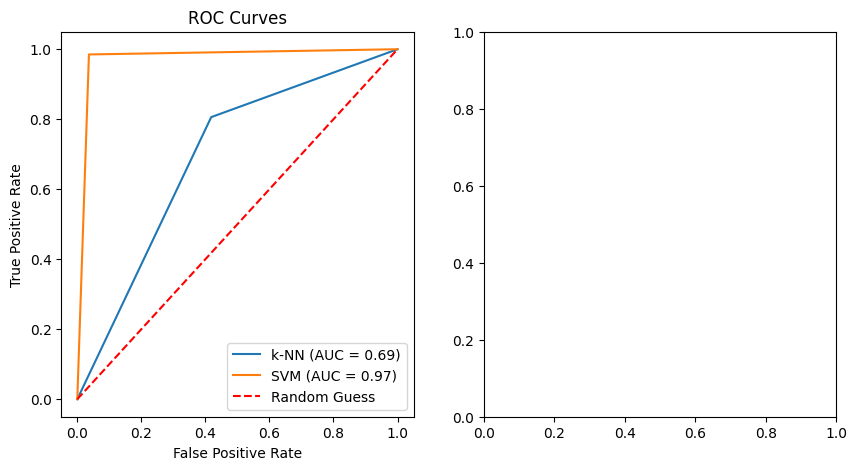

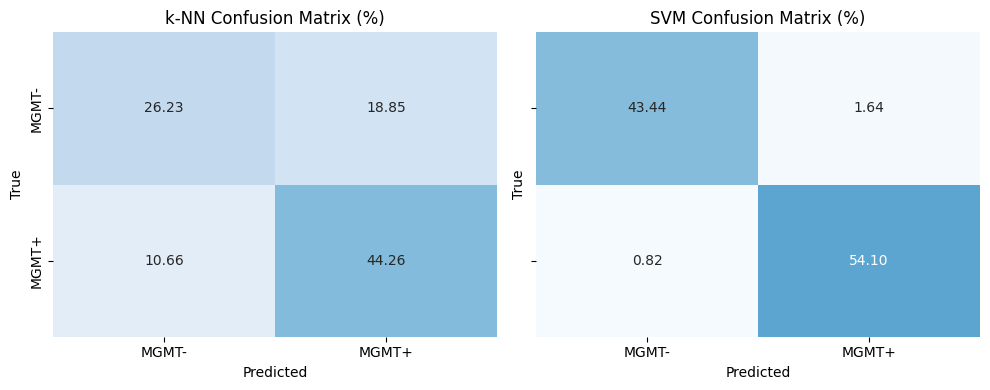

In [14]:
X_train, X_test, y_train, y_test, ids_train, ids_test = load_and_split_hfs(OUTPUT_FILE_PATH_HFS, test_size=0.35)
knn_model, svm_model= train_and_evaluate(X_train, X_test, y_train, y_test)

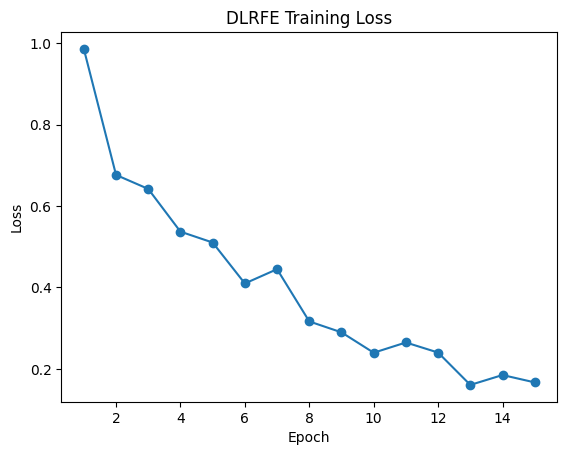

In [ ]:
import matplotlib.pyplot as plt
losses = [0.9861
,0.6765
,0.6421
,0.5371
,0.5104
,0.4098
,0.4449
,0.3165
,0.2897
, 0.2396
, 0.2648
, 0.2400
, 0.1605
, 0.1848
, 0.1667]
plt.plot(range(1, 16), losses, marker='o')
plt.title("DLRFE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("dlrfe_loss.png")

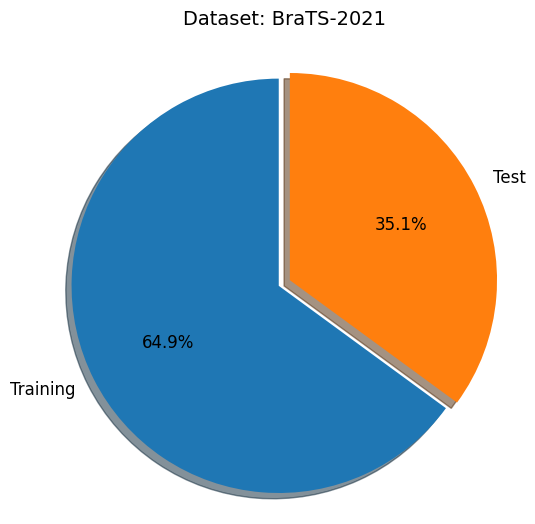

In [14]:
import matplotlib.pyplot as plt


labels = ['Training', 'Test']
sizes = [226, 122] 
colors = ['#1f77b4', '#ff7f0e']  
explode = (0.06, 0)  #


plt.figure(figsize=(6, 6))  
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%.1f%%', 
        shadow=True, startangle=90, textprops={'fontsize': 12, 'color': 'black'})
plt.title('Dataset: BraTS-2021', fontsize=14, pad=20)

# Equal aspect ratio ensures pie is circular
plt.axis('equal')

# Save the chart as an image
plt.savefig('brats2021_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

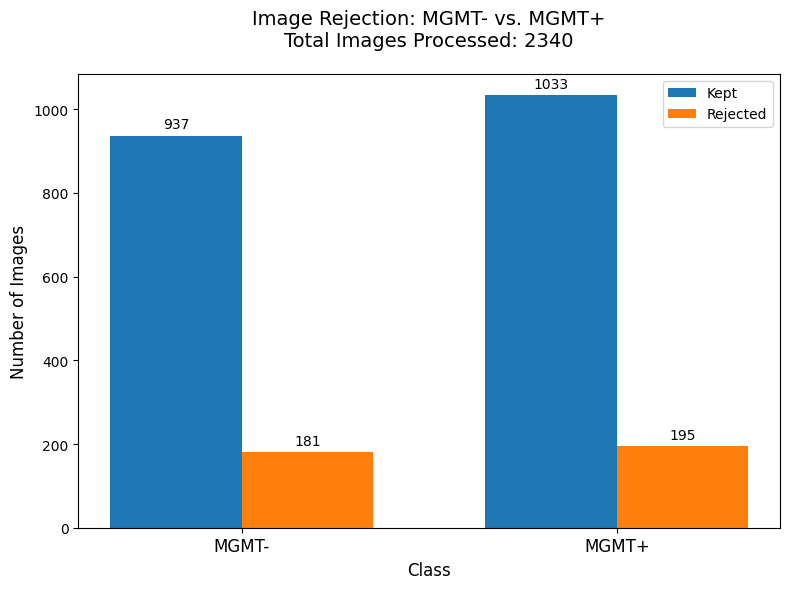

In [25]:
import matplotlib.pyplot as plt

# Data for the bar chart
categories = ['MGMT-', 'MGMT+']
kept_images = [937, 1033]  # Calculated: Total - Rejected
rejected_images = [181, 195]  # From your output
colors = ['#1f77b4', '#ff7f0e']  # Blue for Kept, Orange for Rejected


plt.figure(figsize=(8, 6)) 
bar_width = 0.35
x = range(len(categories))


plt.bar(x, kept_images, bar_width, label='Kept', color=colors[0])
plt.bar([i + bar_width for i in x], rejected_images, bar_width, label='Rejected', color=colors[1])


plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Image Rejection: MGMT- vs. MGMT+\nTotal Images Processed: 2340', fontsize=14, pad=20)
plt.xticks([i + bar_width / 2 for i in x], categories, fontsize=12)
plt.legend()


for i, v in enumerate(kept_images):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10)
for i, v in enumerate(rejected_images):
    plt.text(i + bar_width, v + 10, str(v), ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.savefig('image_rejection_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

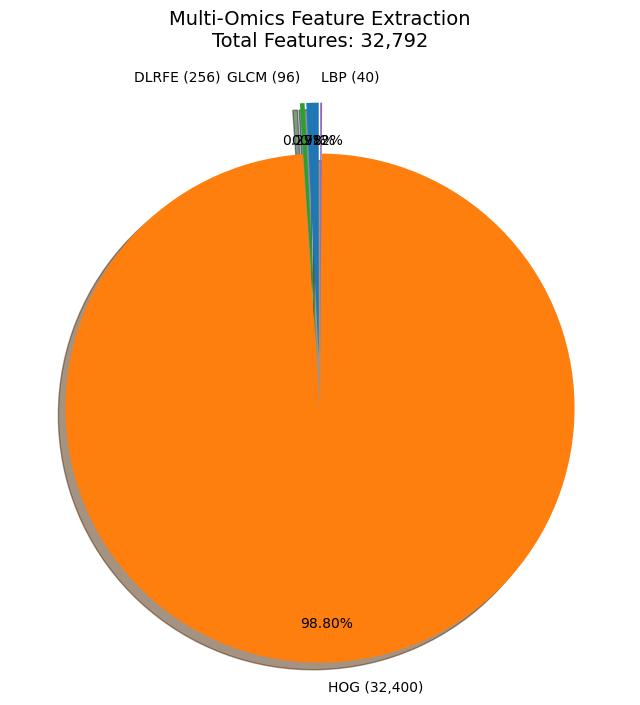

In [121]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ['DLRFE (256)                     ', 'GLCM (96)', 'HOG (32,400)', 'LBP (40)']
sizes = [256, 96, 32400, 40]  # Feature counts
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd']  # Blue, Green, Orange, Purple
explode = (0.2, 0.2, 0, 0.2)  # Explode smaller slices more for visibility

# Create the pie chart
plt.figure(figsize=(8, 8))  # Slightly larger for better text spacing
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%.2f%%', 
        shadow=True, startangle=90, 
        textprops={'fontsize': 10, 'color': 'black'},  # Smaller font
        pctdistance=0.85, labeldistance=1.1)  # Move percentages and labels outside

# Title
plt.title('Multi-Omics Feature Extraction\nTotal Features: 32,792', fontsize=14, pad=20)

# Equal aspect ratio ensures pie is circular
plt.axis('equal')

# Save the chart as an image
plt.savefig('feature_extraction_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

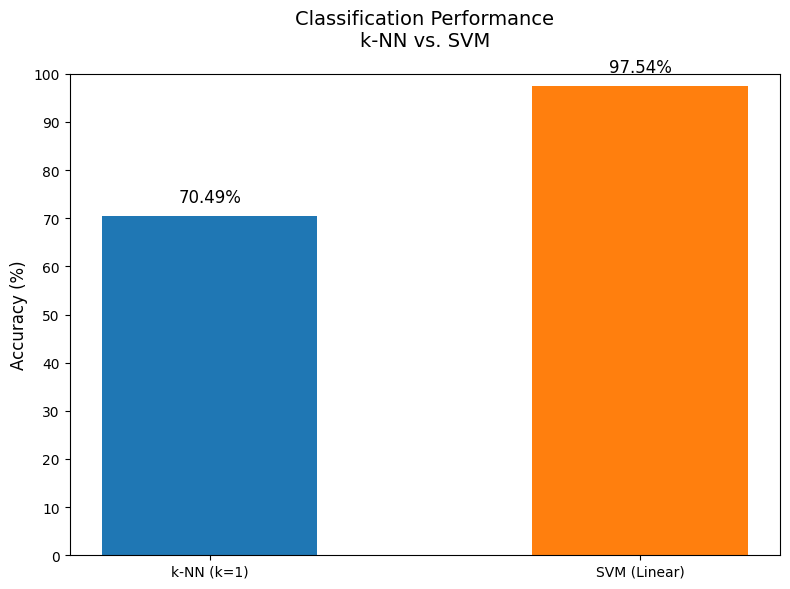

In [16]:
import matplotlib.pyplot as plt

# Data for the bar chart
classifiers = ['k-NN (k=1)', 'SVM (Linear)']
accuracies = [70.49, 97.54]  # Accuracy percentages
colors = ['#1f77b4', '#ff7f0e']  # Blue for k-NN, Orange for SVM

# Create the bar chart
plt.figure(figsize=(8, 6))  # Size suitable for PPT
bars = plt.bar(classifiers, accuracies, color=colors, width=0.5)

# Customize the chart
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Classification Performance\nk-NN vs. SVM', fontsize=14, pad=20)
plt.ylim(0, 100)  # Set y-axis limit to 100% for clarity
plt.yticks(range(0, 101, 10))  # 10% increments

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=12)

# Adjust layout and save
plt.tight_layout()
plt.savefig('classification_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()